In [ ]:
import pandas as pd
import os
import torch

def load_data_from_csv(path_2d, path_3d):
    """
    Loads 2D and 3D data from CSV files and prepares input-output pairs.

    Args:
        path_2d (str): Path to the folder containing 2D data CSV files.
        path_3d (str): Path to the folder containing 3D data CSV files.

    Returns:
        torch.Tensor: 2D input data of shape (num_objects, 21).
        torch.Tensor: 3D output data of shape (num_objects, 31).
    """
    input_2d_data = []
    output_3d_data = []

    print("Starting to load data...")
    
    # Read all CSV files from 2D and 3D folders
    for file_2d, file_3d in zip(sorted(os.listdir(path_2d)), sorted(os.listdir(path_3d))):
        path_file_2d = os.path.join(path_2d, file_2d)
        path_file_3d = os.path.join(path_3d, file_3d)

        print(f"Processing files: {file_2d} and {file_3d}")

        # Skip empty files
        if os.stat(path_file_2d).st_size == 0 or os.stat(path_file_3d).st_size == 0:
            print(f"Skipping empty file: {file_2d} or {file_3d}")
            continue

        try:
            # Read CSV files
            csv_2d = pd.read_csv(path_file_2d, header=None)
            csv_3d = pd.read_csv(path_file_3d, header=None)

            # Validate dimensions
            if csv_2d.shape[1] != 21 or csv_3d.shape[1] != 31:
                print(f"Skipping file with incorrect dimensions: {file_2d} or {file_3d}")
                continue

            # Add rows to data lists
            for index in range(len(csv_2d)):
                input_row = csv_2d.iloc[index].values.astype(float)
                output_row = csv_3d.iloc[index].values.astype(float)
                input_2d_data.append(input_row)
                output_3d_data.append(output_row)

        except pd.errors.EmptyDataError:
            print(f"Skipping empty or invalid file: {file_2d} or {file_3d}")
            continue
        except Exception as e:
            print(f"Error processing file {file_2d} or {file_3d}: {e}")
            continue

    # Convert to torch tensors
    input_2d_tensor = torch.tensor(input_2d_data, dtype=torch.float32)
    output_3d_tensor = torch.tensor(output_3d_data, dtype=torch.float32)

    print("Finished loading data.")
    print(f"Total 2D data shape: {input_2d_tensor.shape}")
    print(f"Total 3D data shape: {output_3d_tensor.shape}")

    return input_2d_tensor, output_3d_tensor

# Paths to data directories
path_2d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\7_only_objects\2d_data"
path_3d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\7_only_objects\3d_data"

# Load data
input_2d_tensor, output_3d_tensor = load_data_from_csv(path_2d, path_3d)

# Print dataset statistics
print("Dataset Statistics:")
print(f"Loaded 2D data mean: {input_2d_tensor.mean(dim=0)}")
print(f"Loaded 2D data std dev: {input_2d_tensor.std(dim=0)}")
print(f"Loaded 3D data mean: {output_3d_tensor.mean(dim=0)}")
print(f"Loaded 3D data std dev: {output_3d_tensor.std(dim=0)}")


In [4]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer2DTo3D(nn.Module):
    def __init__(self, input_dim=21, output_dim=31, d_model=128, nhead=8, num_encoder_layers=6, dim_feedforward=512):
        super(Transformer2DTo3D, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, d_model)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Aggregate sequence for regression
        x = self.fc(x)
        return x

print("Model definition loaded.")


Model definition loaded.


In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare dataset and dataloader
dataset = TensorDataset(input_2d_tensor, output_3d_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, loss
model = Transformer2DTo3D(input_dim=21, output_dim=31)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch in dataloader:
        x, y = batch
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")

# Save model weights
torch.save(model.state_dict(), "transformer_2d_to_3d_v3.pth")
print("Model training completed and weights saved to 'transformer_2d_to_3d_v3.pth'.")


NameError: name 'input_2d_tensor' is not defined

In [ ]:
# Load the model
model = Transformer2DTo3D(input_dim=21, output_dim=31)
model.load_state_dict(torch.load("transformer_2d_to_3d_v3.pth"))
model.eval()
print("Model weights loaded for inference.")

# Inference function
def run_inference(model, input_data):
    """
    Runs inference using the trained model.
    
    Args:
        model (Transformer2DTo3D): Trained model.
        input_data (torch.Tensor): 2D input data (batch_size, seq_len, input_dim).
        
    Returns:
        torch.Tensor: Predicted 3D outputs.
    """
    with torch.no_grad():
        predictions = model(input_data)
    return predictions

# Example inference (Replace `test_input` with actual test data)
test_input = input_2d_tensor[:5].unsqueeze(1)  # Take 5 samples for testing
predictions = run_inference(model, test_input)
print("Predictions:", predictions)


Model weights loaded for inference.
Predictions: tensor([[-0.0168, -0.0397, -0.0044, -0.0443,  0.0351, -0.0636,  0.0375,  0.0005,
         -0.0351, -0.0893,  0.0133,  0.0173,  0.0133,  0.0400, -0.0289, -0.0392,
          0.0453,  0.0141,  0.0240,  0.0441,  0.0234,  0.0034,  0.0345, -0.0130,
         -0.0325, -0.0283, -0.0244, -0.0031, -0.0282,  0.0181, -0.0073],
        [-0.0168, -0.0397, -0.0044, -0.0443,  0.0351, -0.0636,  0.0375,  0.0005,
         -0.0351, -0.0893,  0.0133,  0.0173,  0.0133,  0.0400, -0.0289, -0.0392,
          0.0453,  0.0141,  0.0240,  0.0441,  0.0234,  0.0034,  0.0345, -0.0130,
         -0.0325, -0.0283, -0.0244, -0.0031, -0.0282,  0.0181, -0.0073],
        [-0.0168, -0.0397, -0.0044, -0.0443,  0.0351, -0.0636,  0.0375,  0.0005,
         -0.0351, -0.0893,  0.0133,  0.0173,  0.0133,  0.0400, -0.0289, -0.0392,
          0.0453,  0.0141,  0.0240,  0.0441,  0.0234,  0.0034,  0.0345, -0.0130,
         -0.0325, -0.0283, -0.0244, -0.0031, -0.0282,  0.0181, -0.0073],
   

c:\Users\sakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\sakar\AppData\Local\Temp\ipykernel_22708\3359206704.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objec

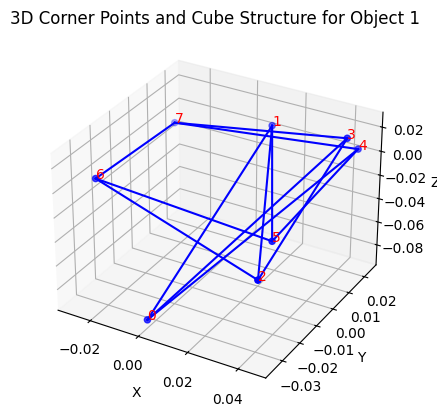

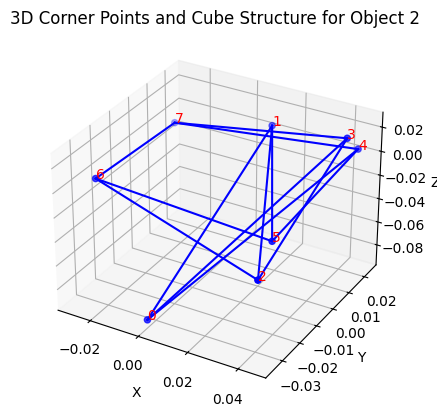

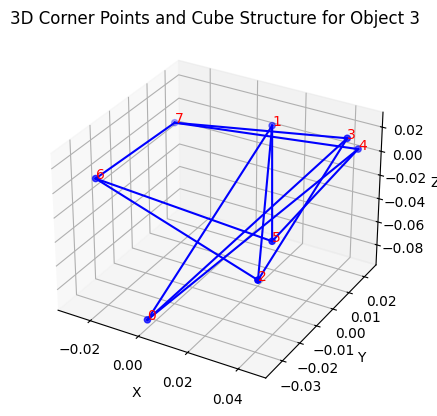

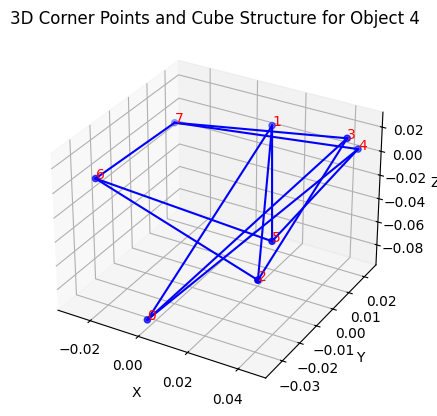

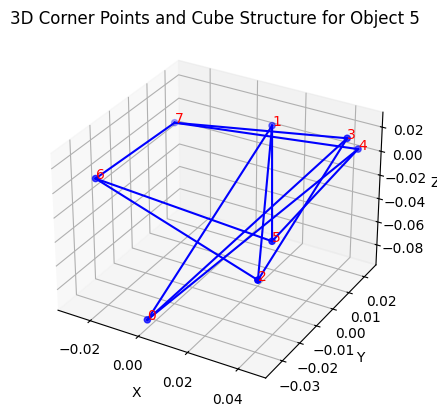

Visualization function loaded.


In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_corners(predictions_3d):
    """
    Plots 3D corner points from predictions and connects them to form a cube structure.

    Args:
        predictions_3d (torch.Tensor): Predictions from the model, where the last 24 elements
                                       correspond to 8 corner points (3D coordinates per corner).
    """
    if predictions_3d is None or len(predictions_3d) == 0:
        print("No predictions to plot.")
        return

    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    # Plot each object’s corners in a 3D space
    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Coordinates of the corners
        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        # Annotate each corner for clarity
        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j}", color="red")

        # Define connections for the cube
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom square
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top square
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges connecting squares
        ]

        # Plot lines for each connection
        for start, end in connections:
            ax.plot(
                [x[start], x[end]],
                [y[start], y[end]],
                [z[start], z[end]],
                'b-'
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points and Cube Structure for Object {i + 1}")
        plt.show()

plot_3d_corners(predictions)
print("Visualization function loaded.")
